In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [4]:
df = pd.read_csv("MELBOURNE_HOUSE_PRICES_LESS.csv")

In [5]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


In [6]:
#Drop unncessary columns
df = df.drop(['Propertycount', 'Address','SellerG'],1)

In [7]:
df.isnull().sum()

Suburb             0
Rooms              0
Type               0
Price          14590
Method             0
Date               0
Postcode           0
Regionname         0
Distance           0
CouncilArea        0
dtype: int64

In [8]:
df.shape

(63023, 10)

In [9]:
#fill missing price values with the mean
df.Price = df.Price.fillna((df.Price.mean()))

In [10]:
df.isnull().sum()

Suburb         0
Rooms          0
Type           0
Price          0
Method         0
Date           0
Postcode       0
Regionname     0
Distance       0
CouncilArea    0
dtype: int64

In [11]:
df.dtypes

Suburb          object
Rooms            int64
Type            object
Price          float64
Method          object
Date            object
Postcode         int64
Regionname      object
Distance       float64
CouncilArea     object
dtype: object

In [12]:
# Convert date to a date object and then to a number for the model
df['Date'] = pd.to_datetime(df['Date'])
df['Date']=df['Date'].map(dt.datetime.toordinal)

In [13]:
df.describe()

,Rooms,Price,Date,Postcode,Distance
count,63023.000000,6.302300e+04,63023.000000,63023.000000,63023.000000
mean,3.110595,9.978982e+05,736541.511813,3125.673897,12.684829
std,0.957551,5.202835e+05,274.291010,125.626877,7.592015
min,1.000000,8.500000e+04,735991.000000,3000.000000,0.000000
25%,3.000000,6.770000e+05,736295.000000,3056.000000,7.000000
50%,3.000000,9.978982e+05,736581.000000,3107.000000,11.400000
75%,4.000000,1.065000e+06,736770.000000,3163.000000,16.700000
max,31.000000,1.120000e+07,737033.000000,3980.000000,64.100000


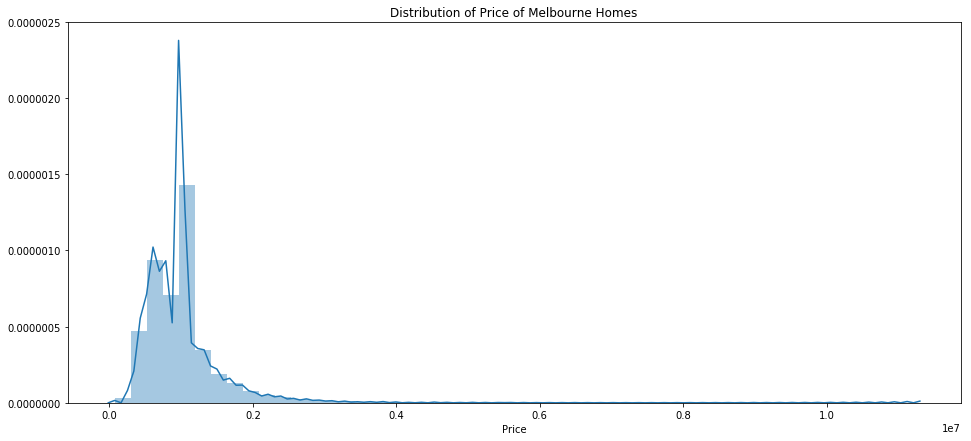

In [14]:
#check data distribution
plt.figure(figsize=(16,7))
sns.distplot(df['Price'])
plt.title('Distribution of Price of Melbourne Homes')
plt.show()

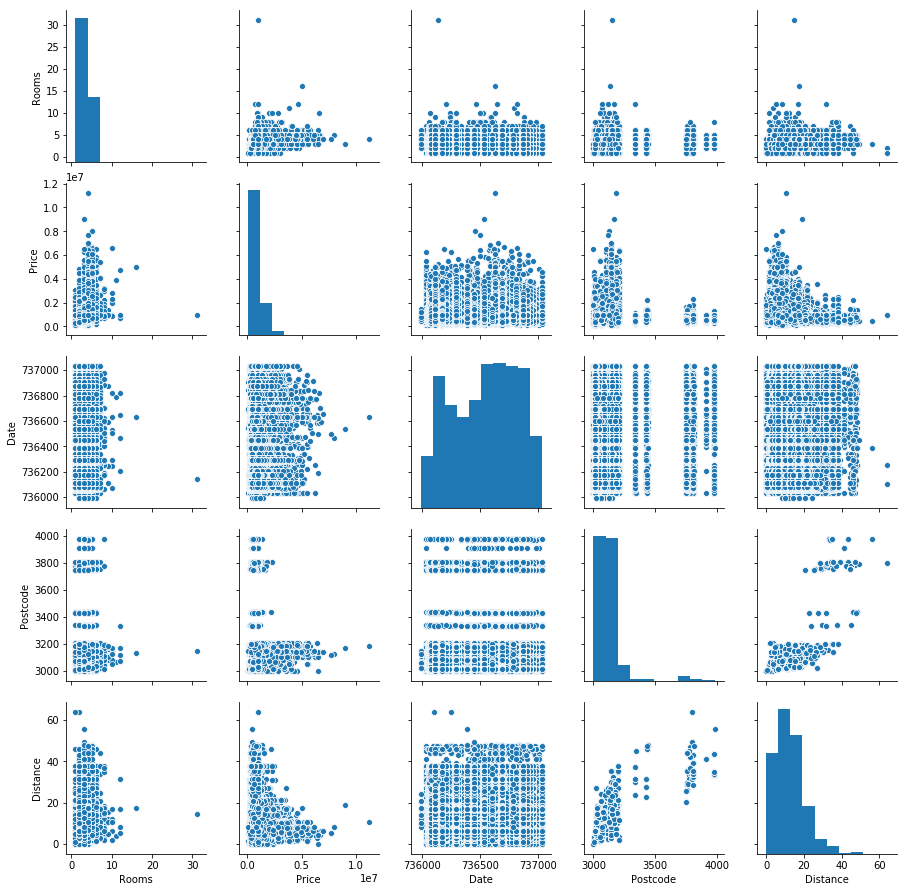

In [15]:
#check for outliers
sns.pairplot(df)

In [16]:
#drop outlier in room and in price
df = df.drop(df['Rooms'].idxmax())
df = df.drop(df['Price'].idxmax())

Text(0.5, 1.0, 'Variable Correlation')

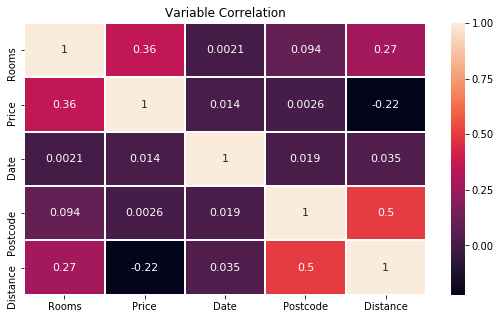

In [17]:
#check for collinearity
plt.figure(figsize=(9,5))
sns.heatmap(df.corr(),linewidth = 1,annot= True, annot_kws={"size": 11})
plt.title('Variable Correlation')

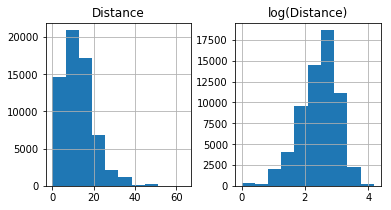

In [18]:
#log transform variables
plt.rcParams['figure.figsize'] = (6.0, 3.0)
price = pd.DataFrame({"Distance":df["Distance"], "log(Distance)":np.log1p(df["Distance"])})
price.hist(bins = 10)
df['Distance'] = np.log1p(df["Distance"])

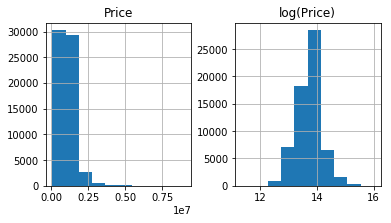

In [19]:
#log transform variables
plt.rcParams['figure.figsize'] = (6.0, 3.0)
price = pd.DataFrame({"Price":df["Price"], "log(Price)":np.log1p(df["Price"])})
price.hist(bins = 10)
df['Price'] = np.log1p(df["Price"])

In [20]:
df.dtypes

Suburb          object
Rooms            int64
Type            object
Price          float64
Method          object
Date             int64
Postcode         int64
Regionname      object
Distance       float64
CouncilArea     object
dtype: object

In [21]:
#make object variables numeric
df = pd.get_dummies(df, columns=["Suburb","Type", "Method", "Regionname", "CouncilArea"])

In [22]:
#get training and testing data
y = df['Price'].values.reshape(-1, 1)
X = df.loc[:, ~(df.columns).isin(['Price'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train.shape
y_train = y_train.ravel()

In [23]:
from sklearn import linear_model
#Build model
regr1 = linear_model.LinearRegression()
model = regr1.fit(X_train, y_train)
print('\nR-squared model on Train:')
print(regr1.score(X_train, y_train))


R-squared model on Train:
0.5833985729977531


In [25]:
#that's a wacky cross validation score. Let's try something else.

#lasso regression
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import r2_score
lasso = Lasso(alpha=3, max_iter=5000)

lasso.fit(X_train, y_train)
y_predict = lasso.predict(X_test)
print( f'r-squared: {r2_score(y_test, y_predict)}')

r-squared: 0.00029605410159505574


In [31]:
#that's a pretty terrible r2. Let's try something else
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_depth=20) 
rfr.fit(X_train, y_train.ravel())
y_predict = rfr.predict(X_test)
print(rfr.get_params)
print()
print( f'r-squared: {r2_score(y_test, y_predict)}')

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

r-squared: 0.6343966997693309


In [32]:
#much better. Let's check the accuracy
model = rfr.fit(X_train, y_train.ravel())
score = cross_val_score(model, X_train, y_train.ravel(), cv=10)
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

Mean cross validation score for train is: 0.6306783280228206
